In [24]:
# Import libraries
import pandas as pd
import numpy as np

from surprise import Dataset
from surprise import Reader
from surprise import NormalPredictor
from surprise import accuracy
from surprise.model_selection import train_test_split

#visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

# File Characteristics

Looked through week 9 content and lab code.
Going to try looking at doing something similar. I think the idea here is to build a similarity matrix based on a particular category feature (in the lab, movie categories), via one hot encoding.
In this one, will try with the beer style out of the train 

# Assignment 3 -- Recommendation Systems

* The final challenge is much like Assignment 2 -- but scoped appropriately for the time and your current abilities.
* It is ratings prediction, just like the movielens recommendations we have seen and many other similar problems.
* The features created are based on Beer Reviews from experts on a website.
* Each beer has been scored between 0 and 5 (on a real scale, so 2.75 or 3.5 is OK).
* The official measure is Mean Average Error (MAE) which is pretty intuitive to work with. Everything supports is and it is easy to interpret.
* A set of features have been created based on the reviewer, the written review, and information about the Beer being reviewed.
* Not all features have to be used, and you can easily create new features using the data if you like.
* The features included are:

![title](Images/A3Features.png)

* Sizes of the files are:
|Size | File|
|---|---|
| 1.9G | features.tsv |
| 88B  | header-features.tsv|
| 48B  | header.tsv |
| 15M  | test.tsv |
| 50M  | train.tsv |
| 16M |  val.tsv |


In [25]:
baseDataDir = "C:/Development/Data/COSC2670/Assignment3/A3data/"

In [26]:
# RowID  BeerID  ReviewerID  BeerName  BeerType  Label
df_train = pd.read_csv(baseDataDir + 'train_wk12.tsv',sep='\t',
                         names=['RowID','BeerID','ReviewerID',
                                  'BeerName','BeerType','rating'])
df_train.head(10)

df_vali = pd.read_csv(baseDataDir + 'val_wk12.tsv',sep='\t',
                         names=['RowID','BeerID','ReviewerID',
                                  'BeerName','BeerType','rating'])
df_vali.head(10)


,RowID,BeerID,ReviewerID,BeerName,BeerType,rating
0,1577147,10420,5279,Buried Hatchet Stout,American Double / Imperial Stout,3.5
1,598391,740,1486,Summertime,Kölsch,3.0
2,1416256,208,2196,Blue Fin Stout,Irish Dry Stout,4.0
3,1353357,575,1995,Moretti La Rossa Birra Doppio Malto,Doppelbock,3.0
4,396142,706,7300,Lion Stout,Foreign / Export Stout,4.0
5,1545829,667,2559,Whirlwind Witbier,Witbier,4.5
6,1276667,895,3624,Grolsch Premium Lager,Euro Pale Lager,2.0
7,631920,119,4597,Tennent's Lager,Euro Pale Lager,3.0
8,987500,11280,9279,80/- (Eighty Shilling),Scottish Ale,2.5
9,1499252,1079,4375,St. Bernardus Abt 12,Quadrupel (Quad),3.5


In [27]:
# RowID BrewerID ABV DayofWeek Month DayofMonth Year TimeOfDay Gender Birthday Text Lemmatized POS_Tag
df_features = pd.read_csv(baseDataDir + 'features-top500.tsv',sep='\t', names=['RowID','BrewerID','ABV','DayofWeek','Month',
                                                                 'DayofMonth','Year','TimeOfDay','Gender',
                                                                 'Birthday','Text','Lemmatized','POS_Tag'])

df_features.head(10)

,RowID,BrewerID,ABV,DayofWeek,Month,DayofMonth,Year,TimeOfDay,Gender,Birthday,Text,Lemmatized,POS_Tag
0,18,1075,7.4,Mon,Jan,2,2012,15:20:04,Male,unknown,Pours a murky light brown with a 1 inch fizzy ...,pour a murky light brown with a 1 inch fizzy t...,VBZ DT JJ NN JJ IN DT CD NN JJ NN NN WDT VBZ I...
1,19,1075,7.4,Sun,Jan,1,2012,06:46:52,Male,unknown,Faint sudsy head with some with some dissipati...,faint sudsy head with some with some dissipate...,NN JJ NN IN DT IN DT VBG JJ NN . JJ JJ NN . DT...
2,20,1075,7.4,Tue,Nov,29,2011,05:51:44,Male,unknown,A new arrival to the West TN area ... Pours qu...,a new arrival to the West TN area ... pour qui...,"DT JJ NN IN DT NNP NNP NN , VBZ PDT DT NN JJR ..."
3,21,1075,7.4,Sat,Nov,5,2011,22:59:57,Male,unknown,Sampled 10/30/11 - Transferring the notes . A ...,sample 10/30/11 - transfer the note . a ruby p...,VBN CD HYPH VBG DT NNS . DT NN VBP IN DT NN NN...
4,22,1075,7.4,Tue,Nov,1,2011,20:40:21,Male,"Oct 14, 1983",This is my first rauchbier . Pours a burnt amb...,this be my first rauchbier . pour a burn amber...,DT VBZ PRP$ JJ NN . VBZ DT VBN NN . JJ NN . NN...
5,23,1075,7.4,Sat,Oct,29,2011,11:18:34,unknown,unknown,A,a,DT
6,24,1075,7.4,Mon,Oct,17,2011,09:04:02,unknown,unknown,"Pours a mahogany color , rich , with a tan hea...","pour a mahogany color , rich , with a tan head...","VBZ DT NN NN , JJ , IN DT JJ NN . DT NN , VBD ..."
7,25,1075,7.4,Tue,Oct,11,2011,10:41:41,unknown,unknown,Pours light caramel brown with reddish highlig...,pour light caramel brown with reddish highligh...,NNS JJ NN JJ IN JJ NNS . DT JJ JJ NN VBZ RB VB...
8,26,1075,7.4,Tue,Oct,11,2011,10:31:22,Male,"Nov 24, 1974",Poured a slightly cloudy deep amber/red color ...,pour a slightly cloudy deep amber/red color wi...,VBD DT RB JJ JJ VBN NN IN DT JJ NN NN IN NN . ...
9,27,1075,7.4,Mon,Sep,19,2011,14:18:29,Male,"Oct 10, 1988",Big thanks to N2168 for knocking this off my w...,big thanks to n2168 for knock this off my want...,JJ NNS IN NN IN VBG DT RP PRP$ NNS . VBN IN DT...


In [28]:

# Setup the data to be just the Reviewer and the Beer(Item) and the Rating Label we want to learn.
dfTrainFeatures = df_train.drop(['RowID','BeerName'],axis=1)
dfValiFeatures = df_vali.drop(['RowID','BeerName'],axis=1)


I think the next two steps aren't required, just for looking at the plot

In [29]:
dfBeerTypeCounts = dfTrainFeatures[["BeerType"]].value_counts()
print(type(dfBeerTypeCounts))
dfBeerTypeCounts

<class 'pandas.core.series.Series'>


BeerType                        
American IPA                        63725
American Double / Imperial IPA      47930
American Pale Ale (APA)             32743
Russian Imperial Stout              30185
American Double / Imperial Stout    28398
                                    ...  
Faro                                  320
English Pale Mild Ale                 262
Roggenbier                            212
Kvass                                 127
Happoshu                               45
Length: 104, dtype: int64

<AxesSubplot:xlabel='BeerType'>

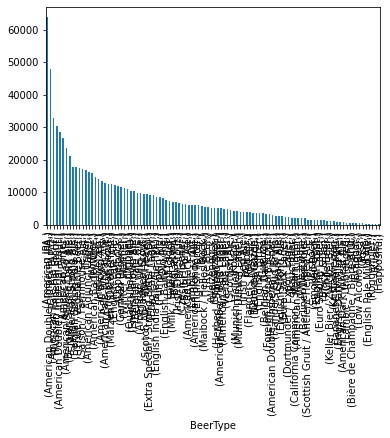

In [30]:
dfBeerTypeCounts.plot(kind="bar")

In [31]:
# This data frame is to get the average ratings by beer
dfAvgByType = dfTrainFeatures[["BeerID", "BeerType"]].drop_duplicates()
dfAvgByType.head()

,BeerID,BeerType
0,8942,Gueuze
1,117,English Pale Ale
2,9165,Extra Special / Strong Bitter (ESB)
3,237,English India Pale Ale (IPA)
4,12301,Saison / Farmhouse Ale


In [32]:
#Add a Column `rating` in movie DF and assign them with the Mean Movie Rating for that Movie.
x = dfTrainFeatures.groupby('BeerID').rating.mean()
x

BeerID
1        3.642857
2        3.523305
3        3.717822
4        3.214674
5        3.720930
           ...   
14224    3.781250
14225    4.285714
14226    4.071429
14227    4.104167
14228    4.200000
Name: rating, Length: 14228, dtype: float64

In [33]:
dfAvgByType = pd.merge(dfAvgByType, x, how="outer", on="BeerID")
dfAvgByType['rating'].fillna('0',inplace=True)
dfAvgByType.head()

,BeerID,BeerType,rating
0,8942,Gueuze,3.824324
1,117,English Pale Ale,3.863782
2,9165,Extra Special / Strong Bitter (ESB),3.963415
3,237,English India Pale Ale (IPA),3.752000
4,12301,Saison / Farmhouse Ale,3.730189


So now we have the dataframe of Beers with the average rating of the beer and the beer type one-hot-encoded

In [34]:
dfAvgByType = pd.concat([dfAvgByType, pd.get_dummies(dfAvgByType["BeerType"], prefix="BeerType", prefix_sep="_")], axis=1)
dfAvgByType.columns = dfAvgByType.columns.str.replace(" ", "").str.replace("/", "")
dfAvgByType = dfAvgByType.drop(columns="BeerType")
dfAvgByType.head()

,BeerID,rating,BeerType_Altbier,BeerType_AmericanAdjunctLager,BeerType_AmericanAmberRedAle,BeerType_AmericanAmberRedLager,BeerType_AmericanBarleywine,BeerType_AmericanBlackAle,BeerType_AmericanBlondeAle,BeerType_AmericanBrownAle,...,BeerType_ScotchAleWeeHeavy,BeerType_ScottishAle,BeerType_ScottishGruitAncientHerbedAle,BeerType_SmokedBeer,BeerType_Tripel,BeerType_ViennaLager,BeerType_Weizenbock,BeerType_Wheatwine,BeerType_WinterWarmer,BeerType_Witbier
0,8942,3.824324,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,117,3.863782,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9165,3.963415,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,237,3.752000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,12301,3.730189,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:

# Now Lets group all the ratings with respect to movieId and count the no of Users
x = dfTrainFeatures.groupby('BeerID',as_index=False).ReviewerID.count()
x.sort_values('ReviewerID',ascending=False,inplace=True)
dfAvgByTypeAndReviewerCounts = pd.merge(dfAvgByType,x,how='outer',on='BeerID')

dfAvgByTypeAndReviewerCounts.drop(columns=[i for i in dfAvgByTypeAndReviewerCounts.columns if i.startswith("BeerType_")],inplace=True)
dfAvgByTypeAndReviewerCounts = dfAvgByTypeAndReviewerCounts.rename(columns={ "ReviewerID": "ReviewerCount" })

dfAvgByTypeAndReviewerCounts.sort_values(['BeerID','rating'],ascending=False)

,BeerID,rating,ReviewerCount
13012,14228,4.200000,5
2683,14227,4.104167,24
6279,14226,4.071429,7
9849,14225,4.285714,7
5688,14224,3.781250,16
...,...,...,...
6353,5,3.720930,43
747,4,3.214674,368
457,3,3.717822,505
3203,2,3.523305,236


The next two, again, maybe not needed, but we're finding the list of Reviewers with the most reviews and their average rating

In [40]:
# Find the user with highest no.of. beer ratings and that users mean rating. 
x = dfTrainFeatures.groupby('ReviewerID',as_index=False).BeerID.count()
y = dfTrainFeatures.groupby('ReviewerID',as_index=False).rating.mean()
x = pd.merge(x,y,how='outer',on='ReviewerID')
x.describe()

,ReviewerID,BeerID,rating
count,10696.000000,10696.000000,10696.000000
mean,5348.500000,79.002244,3.860850
std,3087.813574,158.873386,0.291877
min,1.000000,3.000000,2.045455
25%,2674.750000,11.000000,3.700000
50%,5348.500000,23.000000,3.877034
75%,8022.250000,73.000000,4.045455
max,10696.000000,2567.000000,5.000000


In [41]:
# From below we found that userId - 1704 has given the Highest no.of Ratings with 
# 2567 and an Average of 3.746007 Stars followed by userId-6560 with 2503 Ratings and 
# an Average of 4.113064 Stars and so on …
x.sort_values('BeerID',ascending=False)

,ReviewerID,BeerID,rating
1703,1704,2567,3.746007
6559,6560,2503,4.113064
7206,7207,2503,3.706153
1524,1525,1883,3.826606
1976,1977,1806,3.543189
...,...,...,...
4019,4020,3,4.500000
9199,9200,3,4.333333
3742,3743,3,4.500000
648,649,3,4.333333


The rest of the week 9 notebook seems to be reusable classes and stuff for evaluation and metrics.

Spent some